In [1]:
import tensorflow as tf

/home/neuro/miniconda3/envs/func-neurarch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/neuro/miniconda3/envs/func-neurarch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/neuro/miniconda3/envs/func-neurarch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/neuro/miniconda3/en

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from fna.tasks.symbolic.sequences import SymbolicSequencer
from fna.tasks.preprocessing import ImageFrontend
from fna.networks.rnn.helper import prepare_symbolic_batch

[utils.py:141 - INFO] NumExpr defaulting to 8 threads.


** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.


# **9. Continuous Rate Networks (cRNN)**

In [3]:
from fna.networks.ann import ContinuousRateRNN
from fna.networks.rnn import ReservoirRecurrentNetwork

We consider cRNNs a special case, because they can be seen as an intermediate model, situated in-between SNNs an ANNs. Under some simplifying assumptions, the active state in such models can be considered a coarse model for instantaneous neuronal or population firing rates. This makes these models of interest not only to ML, but also to computational neuroscience. In both fields they have been extensively employed. ()

The main differentiating factor is that cRNNs operate in continuous time, i.e., this category covers network models like: 

$$\boldsymbol{\tau_{x}} \frac{\mathrm{d} \boldsymbol{x}}{\mathrm{dt}}=-\boldsymbol{x}+ W^{\mathrm{rec}} \boldsymbol{r}+W^{\mathrm{in}} \boldsymbol{u}+\boldsymbol{b}^{\mathrm{rec}}+\sqrt{2 \boldsymbol{\tau}} \sigma_{\mathrm{rec}} \zeta$$

$$\boldsymbol{\tau_{r}} \frac{\mathrm{d\boldsymbol{r}}}{\mathrm{dt}}=-\boldsymbol{r} + f\left(\boldsymbol{x}\right)$$

where $\boldsymbol{x}$ and $\boldsymbol{r}$ are the (*hidden* and *active*, respectively) population state variables and $f(.)$ the rate transfer function (a static, point-wise non-linearity). $\boldsymbol{\tau_{x}}$ and $\boldsymbol{\tau_{r}}$ are $N$-dimensional vectors of neuronal time constants (in the simplest cases, $\boldsymbol{\tau}=\tau_{i}, \forall i \in N$), $\boldsymbol{b}^{\mathrm{rec}}$ is a vector of individual neuronal bias terms (i.e. a baseline activation), $W^{\mathrm{rec}}$ and $W^{\mathrm{in}}$ are the recurrent and input weight matrices, respectively and $\boldsymbol{\zeta}$ is a vector of $N$ independent realizations of Gaussian white noise with zero mean and variance scaled by $\sigma{\mathrm{rec}}$. 



The differential equations are integrated numerically, using a forward Euler approximation with step $\delta t$:

$$\boldsymbol{x}_{t}=(1-\boldsymbol{\alpha_{x}}) x_{t-1} + \boldsymbol{\alpha_{x}} \left(W^{\mathrm{rec}} r_{t-1}\right)$$

$$\boldsymbol{r}_{t}=(1-\boldsymbol{\alpha_{r}}) r_{t-1} + \boldsymbol{\alpha_{r}} f\left(\boldsymbol{x}_{t}+W^{\mathrm{in}} u_{t}+b^{\mathrm{rec}}+\sqrt{\frac{2}{\alpha}} \sigma_{\mathrm{rec}} N(0,1)\right)$$

where $\boldsymbol{\alpha_{x}}=\delta t / \boldsymbol{\tau_{x}}$ and $\boldsymbol{\alpha_{r}}=\delta t / \boldsymbol{\tau_{r}}$. Note that we chose this formalism as it allows greater flexibility, applying some common approximations. For example:

* Echo State Network: $\delta t = 1$, $\mathbf{\alpha}_r = 1$, $f=tanh()$
* Binary network: $\mathbf{\alpha}_r = 1$, $f=\Theta()$
* Standard rate networks: $\mathbf{\alpha}_r = 1$, $f=tanh()$

Continuous rate networks can be implemented in two ways: 
* `ContinuousRateNetwork` uses `Tensorflow`
* `ReservoirRecurrentNetwork` is implemented in pure `Python` as it allows more flexibility (e.g. choice of transfer function)

For comparison and testing purposes, an alternative implementation of cRNNs is included, in pure python, the `ReservoirRecurrentNetwork` or `rRNN`. This can be used *passively* (as an untrained reservoir). In any case, if all parameters are equal and learning rate for the cRNN is set to 0, these two implementations should yield similar results.

In [4]:
# system parameters
resolution = 1.

# task parameters
vocabulary_size = 2
n_epochs = 10
n_batches = 20
batch_size = 100
continuous = True

# discrete sequencers
sequencer = SymbolicSequencer(label='random sequence', set_size=vocabulary_size)
image_mnist = ImageFrontend(path='../data/mnist/', label='mnist', vocabulary=sequencer.tokens)

# continuous sequencers
signal_pars = {
    'duration': 5., # [ms]
    'amplitude': 1., # [max. rate]
    'kernel': ('box', {}),# (kernel, {kernel_pars})
    'dt': resolution # [ms]
}
image_mnist.unfold(to_signal=True, **signal_pars)
image_mnist.embedding_dimensions = image_mnist.dynamic_embedding.embedding_dimensions

[sequences.py:91 - INFO] Generating symbolic sequencer
[preprocessing.py:89 - INFO] MNIST target directory is not empty! Loading existing data...
[preprocessing.py:54 - INFO] Concatenating dataset (original partition in train+test will be lost): 
	- T=70000


1) rRNN

In [5]:
N = 1000
resolution = 1.
taus = np.ones(N) * 100.
noise = np.sqrt(2*(resolution/taus)) * 0.5
batch_time = (signal_pars['duration'] * batch_size) / resolution

net_params = {
    'N': N,
    'transfer_fcn': 'sigmoid', # tanh, relu, sigmoid, step
    'EI_ratio': 0.8, # set ==0 if no division of E/I is necessary
    'tau_x': np.ones(N)*resolution,
    'tau_r': np.ones(N) * 100.,
    'noise': noise.astype(np.float32),
    'initial_state': (np.random.uniform, {'low': 0., 'high': 1.}),
    'learning_rate': 1e-2}

connection_params = {
    'w_in': {
        'density': 1.,
        'distribution': (np.random.uniform, {'low': -1., 'high': 1.})}, # np.array(nU, N) or (distribution, {parameters})
    'w_rec': {
        'ei_balance': 4., # wI = ei_balance * wE
        'density': .1,
        'distribution': (np.random.gamma, {'shape': 0.2, 'scale': 1.})},
    'w_out': {
        'density': 1.,
        'distribution': (np.random.gamma, {'shape': 0.1, 'scale': 1.})}
}

In [6]:
extractor_parameters = {
    'r_@offset': {
        'population': None,
        'variable': 'active',
        'sampling_times': ['stim_offset']}}
decoding_parameters = {
    'SGD-Regression': {
        'algorithm': "sgd-reg",
        'extractor': 'r_@offset',
        'save': True
    },}

rnn = ReservoirRecurrentNetwork(label='rRNN-random-amorphous', network_parameters=net_params,
                                connection_parameters=connection_params, input_dim=image_mnist.embedding_dimensions,
                                extractors=extractor_parameters, decoders=decoding_parameters,
                                output_dim=vocabulary_size, dt=resolution)

[rnn_network.py:37 - INFO] Initializing rRNN-random-amorphous architecture (Python-simulated)
[rnn_network.py:24 - INFO] ========================================================
[rnn_network.py:25 - INFO]  rRNN-random-amorphous architecture (Python-simulated):
[rnn_network.py:26 - INFO] --------------------------------------------------------
[rnn_network.py:27 - INFO] - Size: 1000
[rnn_network.py:28 - INFO] - Neuron models: sigmoid
[connectivity.py:78 - INFO] Connecting network: rRNN-random-amorphous
[connectivity.py:81 - INFO]     - w_in
[connectivity.py:81 - INFO]     - w_rec
[connectivity.py:81 - INFO]     - w_out
[rnn_network.py:146 - INFO] Setting E/I connections [g=4.0]
[rnn_network.py:125 - INFO] Preparing system variables:
[rnn_network.py:113 - INFO] Initializing hidden state variable
[rnn_network.py:113 - INFO] Initializing active state variable
[rnn_network.py:24 - INFO] ========================================================
[rnn_network.py:25 - INFO]  rRNN-random-amorphou

In [7]:
# Train set
train_batch = prepare_symbolic_batch(simulator=rnn.simulator, n_batches=n_batches, batch_size=batch_size,
                                     sequencer=sequencer, continuous_embedding=image_mnist,
                                     batch_time=int(batch_time), as_tensor=True, signal_pars=signal_pars,
                                     decoder_output_pars=None)
train_results = rnn.train(data_batch=train_batch, n_epochs=n_epochs, output_parsing=None, symbolic=True, save=False)

# Test set
test_batch = prepare_symbolic_batch(simulator=rnn.simulator,
                                    n_batches=1, batch_size=batch_size,
                                    sequencer=sequencer, continuous_embedding=image_mnist,
                                    batch_time=int(batch_time), as_tensor=True, signal_pars=signal_pars,
                                    decoder_output_pars=None)
test_results = rnn.test(data_batch=test_batch, output_parsing='k-WTA', symbolic=True, save=False)


Generating batches: 100%|██████████| 20/20 [08:31<00:00, 25.60s/it]
[rnn_network.py:228 - INFO] Processing batch Batch=1_epoch=1
Simulating: 100%|██████████| 500/500 [00:00<00:00, 684.37it/s]
[state_decoder.py:74 - INFO] Initializing and connecting decoder...
[state_decoder.py:84 - INFO] Creating readouts:
[readouts.py:48 - INFO]   - SGD-Regression trained with sgd-reg on classification, using state r_@offset
[state_decoder.py:151 - INFO] Processing readout [SGD-Regression] with state [r_@offset]
/home/neuro/Desktop/dev/func-neurarch/fna/decoders/readouts.py:92: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
[readouts.py:202 - INFO]   - Training readout with [sgd-reg] on [classification] task
[readouts.py:332 - INFO] Performing GridSearchCV for best SGDRegressor...
[readouts.py:334 - INFO] Best Fit: MultiOutputRegressor(estimator=SGDRegressor(alpha=1.0, average=False,
                                         

In [9]:
# prepare variables for analysis
loss = [train_results['dec_loss']['Batch={}_epoch={}'.format(n_batches, epoch+1)]['{}-classification'.format(rnn.decoders.readouts[0].label)]['raw-MSE'] for epoch in range(n_epochs)]
states = train_results['states']
outputs = train_results['outputs']

batch_time_axis = np.arange(0., signal_pars['duration'] * batch_size, resolution)
input_signal = train_batch['inputs'][:, -1, :].T
state_matrix = states[-1]
output = outputs[-1][0]
target = train_batch['targets'][:, -1, :].T

Text(0, 0.5, 'Training Loss')

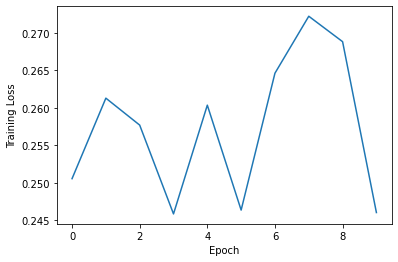

In [10]:
fig, ax = plt.subplots()
ax.plot(loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")

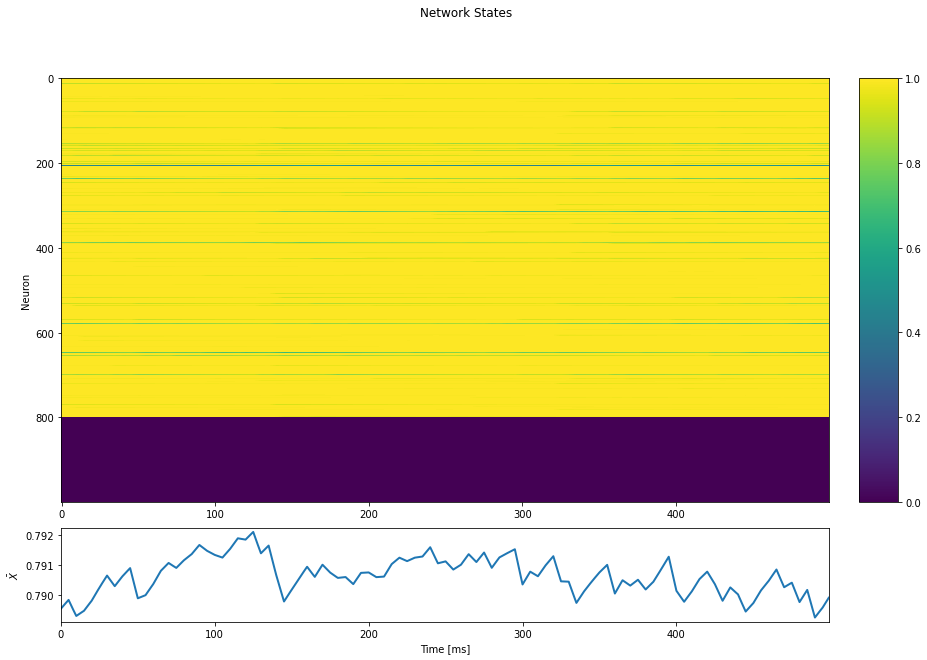

In [11]:
from fna.tools.visualization.plotting import plot_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

state_matrix = train_results['states'][-1]
fig, (ax11, ax12) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [18, 4], 'hspace': 0.1}, sharex=False, figsize=(15, 10))
fig.suptitle("Network States")
_, ax11 = plot_matrix(state_matrix, ax=ax11, save=False, display=False, data_label=None)
ax11.set_ylabel('Neuron')
ax12.plot(batch_time_axis, state_matrix.mean(0), lw=2)
divider2 = make_axes_locatable(ax12)
cax2 = divider2.append_axes("right", size="5%", pad="4%")
cax2.remove()
ax12.set_xlabel("Time [ms]")
ax12.set_xlim([batch_time_axis.min(), batch_time_axis.max()])
ax12.set_ylabel(r"$\bar{X}$")
plt.show()

2) cRNN

In [12]:
# timeconstants, transfer function, weight_parameters
N = 1000
taus = np.ones(N) * 20.
noise = np.sqrt(2*(resolution/taus)) * 0.5

net_params = {
    'N': N,
    'transfer_fcn': 'tanh', # tanh, relu, sigmoid
    # 'connection_density': 1.,
    'EI_ratio': 0.8, # set ==0 if no division of E/I is necessary
    'tau_x': taus,
    'tau_r': taus,
    'noise': noise.astype(np.float32),
    'initial_state': (np.random.uniform, {'low': 0., 'high': 1.}),
    'learning_rate': 2e-2
}
connection_params = {
    'w_in': {
        'density': 1.,
        'distribution': (np.random.gamma, {'shape': 0.2, 'scale': 1.})
    }, # np.array(nU,N) or (distribution, {parameters})
    'w_rec': {
        'ei_balance': 2., # wI = ei_balance * wE
        'density': 0.1,
        'distribution': (np.random.gamma, {'shape': 0.2, 'scale': 1.})
    },
    'w_out': {
        'density': 1.,
        'distribution': (np.random.gamma, {'shape': 0.2, 'scale': 1.})
    }
}

extractor_parameters = {
    'hidden': {
        'population': None,
        'variable': 'active_state',
        'sampling_times': ['stim_offset']}}
decoding_parameters = {
    'reg': {
        'algorithm': "pinv-sgd",
        'extractor': 'hidden',
        'save': True
    },
}
decoder_outputs = {
    'max_memory': 0,
    'max_chunk': 0,
    'max_prediction': 0,
    'chunk_memory': False,
    'chunk_prediction': False}

In [13]:
rnn = ContinuousRateRNN(label='ContinuousRNN', network_parameters=net_params,
                        connection_parameters=connection_params, input_dim=image_mnist.dimensions,
                        output_dim=len(sequencer.tokens), dt=resolution, extractors=extractor_parameters,
                        decoders=decoding_parameters)

[ann_network.py:299 - INFO] Initializing ContinuousRNN architecture (TensorFlow-simulated)
[ann_network.py:458 - INFO] Preparing system variables
[ann_network.py:394 - INFO] Initializing state variables:
[ann_network.py:394 - INFO] Initializing state variables:
[connectivity.py:78 - INFO] Connecting network: ContinuousRNN
[connectivity.py:81 - INFO]     - w_in
[connectivity.py:81 - INFO]     - w_rec
[connectivity.py:81 - INFO]     - w_out
[ann_network.py:417 - INFO] Setting E/I connections [g=2.0]
[ann_network.py:383 - INFO] ========================================================
[ann_network.py:384 - INFO]  ContinuousRNN architecture (TensorFlow-simulated):
[ann_network.py:385 - INFO] --------------------------------------------------------
[ann_network.py:386 - INFO] - Size: 1000
[ann_network.py:387 - INFO] - Neuron models: tanh


In [14]:
# Train set
train_batch = prepare_symbolic_batch(simulator=rnn.simulator, n_batches=n_batches, batch_size=batch_size,
                                     sequencer=sequencer, continuous_embedding=image_mnist,
                                     batch_time=int(batch_time), as_tensor=True, signal_pars=signal_pars,
                                     decoder_output_pars=decoder_outputs)
train_results = rnn.train(data_batch=train_batch, n_epochs=n_epochs, weight_penalty=0., rate_penalty=0.,
                          clip_max_gradient=0.1, gpu_id=None, symbolic=True, verbose=True, save=False)

# Test set
test_batch = prepare_symbolic_batch(simulator=rnn.simulator,
                                    n_batches=1, batch_size=batch_size,
                                    sequencer=sequencer, continuous_embedding=image_mnist,
                                    batch_time=int(batch_time), as_tensor=True, signal_pars=signal_pars,
                                    decoder_output_pars=decoder_outputs)
test_results, decoder_accuracy = rnn.test(data_batch=test_batch, output_parsing='k-WTA', symbolic=True, save=False)

Generating batches: 100%|██████████| 20/20 [08:56<00:00, 26.83s/it]
[ann_network.py:626 - INFO] Running TF session on /cpu:0
[state_decoder.py:74 - INFO] Initializing and connecting decoder...
[state_decoder.py:84 - INFO] Creating readouts:
[readouts.py:48 - INFO]   - reg trained with pinv-sgd on classification, using state hidden
[state_decoder.py:151 - INFO] Processing readout [reg] with state [hidden]
/home/neuro/Desktop/dev/func-neurarch/fna/decoders/readouts.py:92: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
[readouts.py:202 - INFO]   - Training readout with [pinv-sgd] on [classification] task
[readouts.py:417 - INFO] Performing GridSearchCV for Linear Least Squares-SGD...
[readouts.py:419 - INFO] Best Fit: MultiOutputRegressor(estimator=SGDRegressor(alpha=0.001, average=False,
                                            early_stopping=False, epsilon=0.1,
                                            et

ValueError: Cannot feed value of shape (500, 1, 784) for Tensor 'input:0', which has shape '(500, 20, 784)'

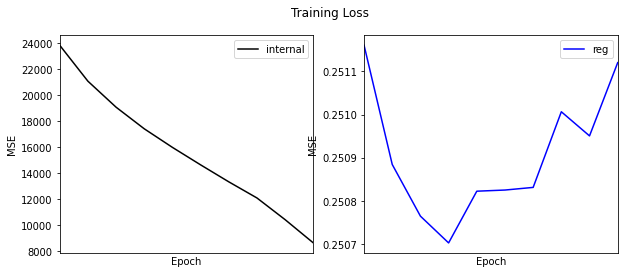

In [15]:
decoders = [x for x in rnn.decoders.readouts if x.task == 'classification']
readout_labels = [x.label+'-'+x.task for x in decoders]
decoder_losses = {k: [] for k in readout_labels}
for batch, losses in train_results['dec_loss'].items():
    for r_label in readout_labels:
        decoder_losses[r_label].append(losses[r_label]['raw-MSE'])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Training Loss")
x_ticks = np.arange(n_epochs)+1
ax[0].plot(np.arange(n_epochs)+1, train_results['losses'], 'k', label="internal")
ax[0].set_xticks(x_ticks[::10]-1)
ax[0].set_xlim([x_ticks.min(), x_ticks.max()])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("MSE")
ax[0].legend()
for idx, (k, v) in enumerate(decoder_losses.items()):
    label = '-'.join(k.split('-')[:-1])
    ax[1].plot(np.arange(n_epochs)+1, v, color='b', label=label)
ax[1].set_xticks(x_ticks[::10]-1)
ax[1].set_xlim([x_ticks.min(), x_ticks.max()])
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("MSE")
ax[1].legend()

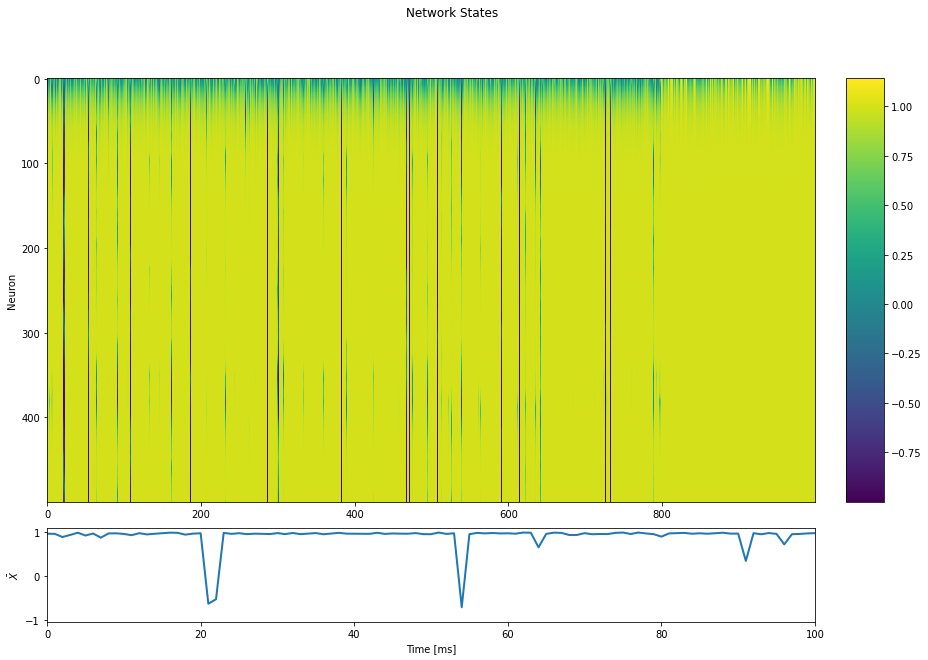

In [16]:
state_matrix = train_results['states'][-1][:, -1, :]
fig, (ax11, ax12) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [18, 4], 'hspace': 0.1}, sharex=False, figsize=(15, 10))
fig.suptitle("Network States")
_, ax11 = plot_matrix(state_matrix, ax=ax11, save=False, display=False, data_label=None)
ax11.set_ylabel('Neuron')
ax12.plot(state_matrix.mean(0), lw=2)
divider2 = make_axes_locatable(ax12)
cax2 = divider2.append_axes("right", size="5%", pad="4%")
cax2.remove()
ax12.set_xlabel("Time [ms]")
ax12.set_xlim([0., 100.])
ax12.set_ylabel(r"$\bar{X}$")
plt.show()